# Imports/Set up

In [1]:
# Specific to NERSC: Set up kernel using: https://docs.nersc.gov/services/jupyter/how-to-guides/
from __future__ import annotations

import math
import os
import sys

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from neuralop import H1Loss
from neuralop import LpLoss
from neuralop.data.datasets.darcy import DarcyDataset
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from neuralop.models import FNO
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.utils import count_model_params
from neuralop.utils import get_project_root
from neuralop.utils import spectrum_2d
from torch.utils.data import DataLoader

root_dir = get_project_root() / 'neuralop/data/datasets/data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

device=device(type='cuda')


# Train FNO At Different Resolutions

In [2]:
# first download data
data = DarcyDataset(
    root_dir=root_dir,
    n_train=100,
    n_tests=[32, 32, 32, 32],
    batch_size=16,
    test_batch_sizes=[16, 16, 16, 16],
    train_resolution=128,  # change resolution to download different data
    test_resolutions=[16, 32, 64, 128],
)

Loading test db for resolution 16 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 64 with 32 samples 
Loading test db for resolution 128 with 32 samples 


In [3]:
# load darcy flow dataset


def load_darcy_flow_small(
    n_train,
    n_tests,
    data_root=root_dir,
    test_resolutions=(16, 32),
    train_resolution=16,
):
    """Docstring."""
    batch_size = 16
    test_batch_sizes = [batch_size] * len(test_resolutions)

    dataset = DarcyDataset(
        root_dir=data_root,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=False,
        encode_output=True,
        channel_dim=1,
        encoding='channel-wise',
        download=True,
    )

    # return dataloaders for backwards compat
    train_loader = DataLoader(
        dataset.train_db,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        persistent_workers=False,
    )

    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(
            dataset.test_dbs[res],
            batch_size=test_bsize,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=False,
        )

    return train_loader, test_loaders, dataset.data_processor

In [4]:
df = pd.DataFrame(
    columns=['train_resolution', 'test_resolution', 'loss_type', 'loss'],
)
trained_models = {}  # at different resolutions
for train_resolution in [16, 32, 64, 128]:
    # get data
    train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000,
        # batch_size=16,
        train_resolution=train_resolution,
        test_resolutions=[16, 32, 64, 128],
        n_tests=[100, 100, 100, 100],
        # test_batch_sizes=[32, 32, 32, 32],
    )

    # incrementally vary modes
    incremental = True
    starting_modes = (16, 16)
    if incremental:
        starting_modes = (2, 2)

    # Set up model
    model = FNO(
        max_n_modes=(16, 16),
        n_modes=starting_modes,
        hidden_channels=32,
        in_channels=1,
        out_channels=1,
    )
    model = model.to(device)
    n_params = count_model_params(model)

    # optimizer + data
    optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    data_transform = IncrementalDataProcessor(
        in_normalizer=None,
        out_normalizer=None,
        device=device,
        subsampling_rates=[2, 1],
        dataset_resolution=16,
        dataset_indices=[2, 3],
        epoch_gap=10,
        verbose=True,
    )

    data_transform = data_transform.to(device)

    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    train_loss = h1loss
    eval_losses = {'h1': h1loss, 'l2': l2loss}
    print('\n### N PARAMS ###\n', n_params)
    print('\n### OPTIMIZER ###\n', optimizer)
    print('\n### SCHEDULER ###\n', scheduler)
    print('\n### LOSSES ###')
    print('\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###')
    print(f'\n * Train: {train_loss}')
    print(f'\n * Test: {eval_losses}')
    sys.stdout.flush()

    # Finally pass all of these to the Trainer
    trainer = IncrementalFNOTrainer(
        model=model,
        n_epochs=20,
        data_processor=data_transform,
        device=device,
        verbose=False,
        incremental_loss_gap=False,
        incremental_grad=True,
        incremental_grad_eps=0.9999,
        incremental_loss_eps=0.001,
        incremental_buffer=5,
        incremental_max_iter=1,
        incremental_grad_max_iter=2,
    )

    # train
    end_stats = trainer.train(
        train_loader,
        test_loaders,
        optimizer,
        scheduler,
        regularizer=False,
        training_loss=train_loss,
        eval_losses=eval_losses,
    )

    trained_models[train_resolution] = trainer.model

    # save stats
    for k, v in end_stats.items():
        s = k.split('_')

        if 'h1' in s or ('l2' in s):
            row = {
                'train_resolution': train_resolution,
                'test_resolution': s[0],
                'loss_type': s[1],
                'loss': v.item(),
            }
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8

### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x7f30d3be4250>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x7f30d3be4250>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x7f30d3d810c0>}
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16


/tmp/ipykernel_2190384/648901031.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8

### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x7f2f599f6800>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x7f2f599f6800>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x7f2f599f5420>}
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16
Loading test db for resolution 16 with 100 samples 
Loading test db 

Text(0.5, 1.0, 'Training resolution affect on Test Performance')

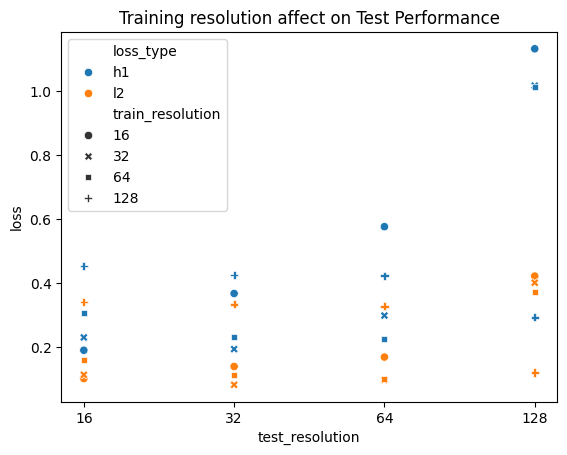

In [5]:
sns.scatterplot(
    data=df,
    x='test_resolution',
    y='loss',
    hue='loss_type',
    style='train_resolution',
)
plt.title('Training resolution affect on Test Performance')

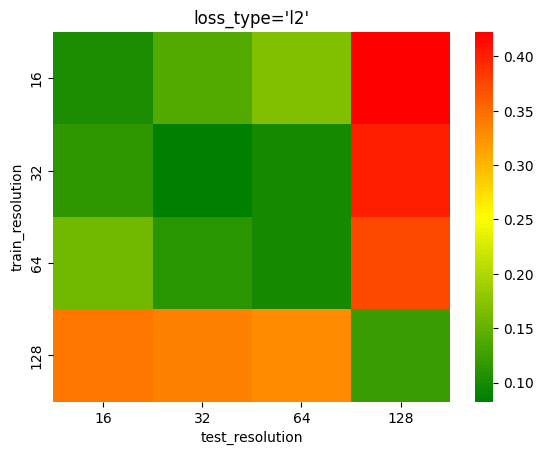

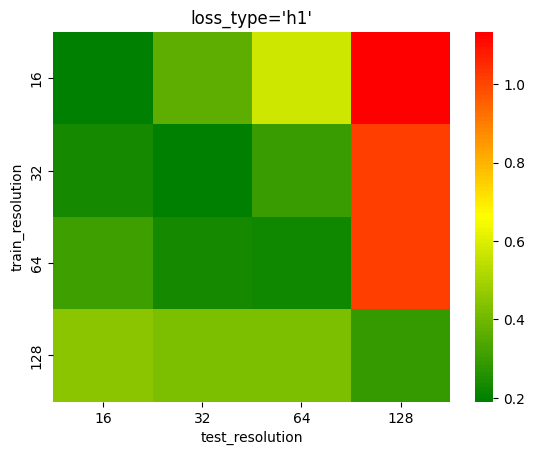

In [6]:
# Define colormap from green (high engagement) to red (low engagement)
cmap = mcolors.LinearSegmentedColormap.from_list(
    'green_red',
    ['green', 'yellow', 'red'],
    N=100,
)
for loss_type in ['l2', 'h1']:
    heat = df[df.loss_type == loss_type].pivot(
        index='train_resolution',
        columns='test_resolution',
        values='loss',
    )
    heat = heat.loc[:, ['16', '32', '64', '128']]
    sns.heatmap(heat, cmap=cmap)
    plt.title(f'{loss_type=}')
    plt.show()

# Visualize Loss on Different Frequencies

Model trained on resolution of 16 x 16 and evaluated on 128 x 128 data

In [7]:
# install a filtering library and include a versioning work around
%pip install hdaf-filter==0.1.1

# Monkeypatch
import numpy as np
from scipy.special import factorial

np.math = type('math', (), {})()
np.math.factorial = factorial

Note: you may need to restart the kernel to use updated packages.


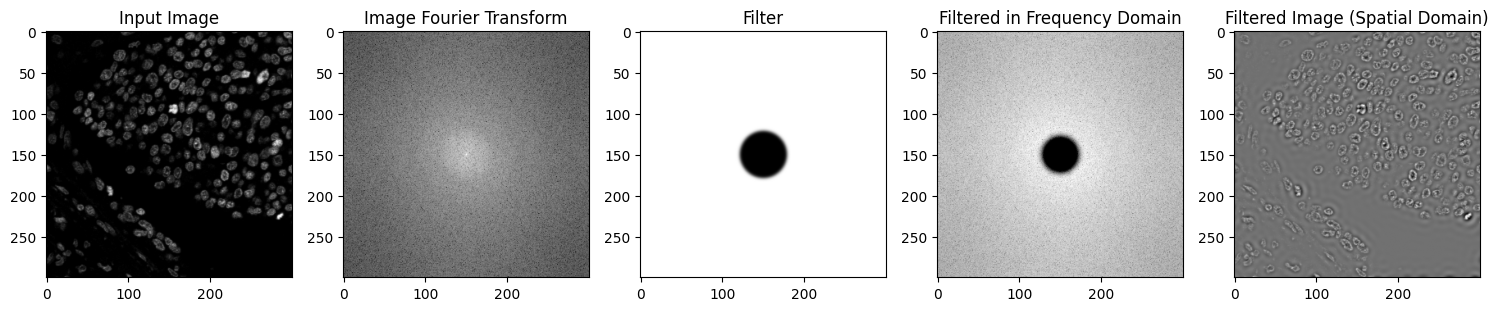

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from hdaf_filter import hdaf
from hdaf_filter import input_output

# This is the basics of how to do filtering on an image


# --- Load image ---
# file_path = "" # <- Here you set the path to your image
# img = tifffile.imread(file_path)
file_name = 'Cells_01.tif'
if not os.path.exists(file_name):
    !wget https://github.com/paul-hernandez-herrera/hdaf_filtering/raw/03e58207ecc8c011b66325dc1e60912dd372ead8/test_data/2d/Cells_01.tif
img = input_output.imread(file_name)
# plt.imshow(img, cmap='gray')

# --- Apply HDAF filtering ---
obj = hdaf.filt(img)

# Get high-pass filter and Fourier transform of the image
high_pass_filter = obj.get_filter('high_pass', 3.0)
img_fourier = obj.img_FT

# Center the filter and Fourier transform
filter_centered = np.fft.fftshift(high_pass_filter)
fourier_centered = np.fft.fftshift(img_fourier)

# Apply the filter in the frequency domain
filtered_fourier = filter_centered * fourier_centered

# Inverse Fourier transform to obtain the filtered image in spatial domain
filtered_img = np.real(np.fft.ifftn(np.fft.ifftshift(filtered_fourier)))

# --- Plot results ---
fig, axs = plt.subplots(1, 5, figsize=(15, 15))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Input Image')

axs[1].imshow(np.log(np.abs(fourier_centered[0]) + 1), cmap='gray')
axs[1].set_title('Image Fourier Transform')

axs[2].imshow(filter_centered[0], cmap='gray')
axs[2].set_title('Filter')

axs[3].imshow(np.log(np.abs(filtered_fourier[0]) + 1), cmap='gray')
axs[3].set_title('Filtered in Frequency Domain')

axs[4].imshow(filtered_img[0], cmap='gray')
axs[4].set_title('Filtered Image (Spatial Domain)')

plt.tight_layout()
plt.show()

In [9]:
# grab trained model
model = trained_models[16]
model = model.to(device)
model = model.eval()

data_transform = data_transform.to(device)
for _idx, sample in enumerate(test_loaders[128]):  # resolution 128
    model_input = data_transform.preprocess(sample)
    with torch.no_grad():
        out = model(**model_input)

# grab a single input from the last batch
model_input = sample['x'][0, :, :, :].unsqueeze(dim=0)
with torch.no_grad():
    model_output = model(x=model_input)
ground_truth = sample['y'][0, :, :, :].unsqueeze(dim=0)

# convert to plotable form
model_input = model_input[0, 0, :, :].cpu().numpy()
model_output = model_output[0, 0, :, :].cpu().numpy()
ground_truth = ground_truth[0, 0, :, :].cpu().numpy()

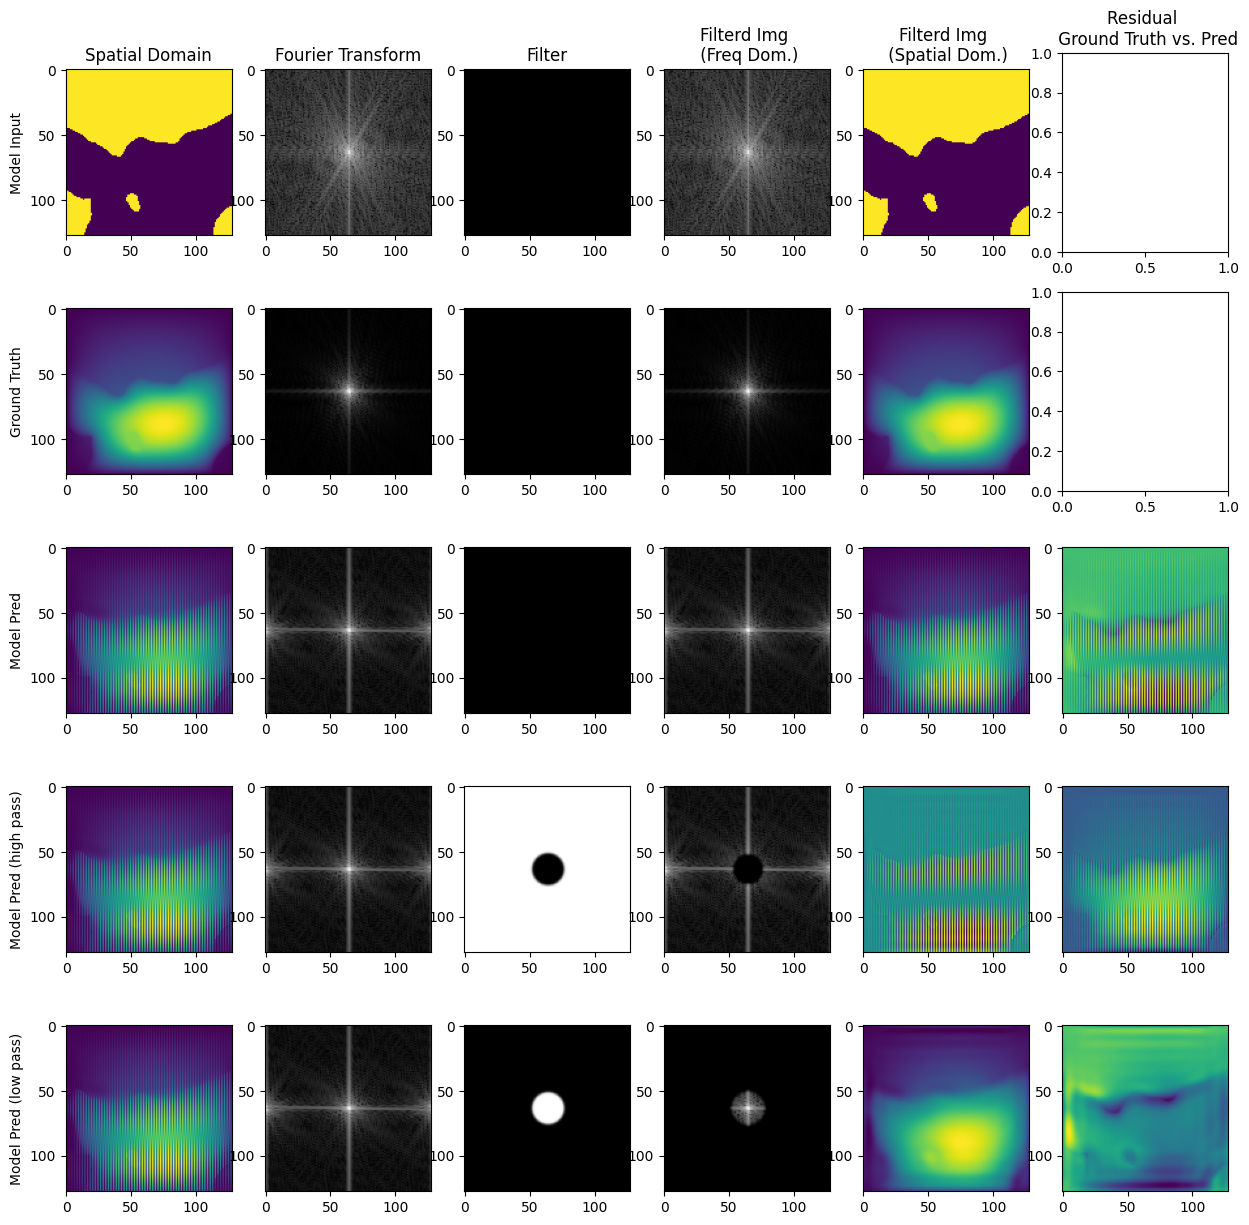

In [10]:
# Apply Filtering to my data

zero = 0
one = 1
two = 2
three = 3
four = 4

num_subplots = 5
fig, axs = plt.subplots(num_subplots, 6, figsize=(15, 15))
for y_idx in range(num_subplots):
    if y_idx == zero:
        img = model_input
        y_label = 'Model Input'

    if y_idx == one:
        img = ground_truth
        y_label = 'Ground Truth'

    if y_idx == two:
        img = model_output
        y_label = 'Model Pred'

    if y_idx == three:
        img = model_output
        y_label = 'Model Pred (high pass)'

    if y_idx == four:
        img = model_output
        y_label = 'Model Pred (low pass)'

    axs[y_idx, 0].set_ylabel(y_label)

    # input fig
    axs[0, 0].set_title('Spatial Domain')
    axs[y_idx, 0].imshow(img)

    obj = hdaf.filt(img)

    # Get high-pass filter and Fourier transform of the image
    high_pass_filter = obj.get_filter('high_pass', 3.0)
    low_pass_filter = obj.get_filter('low_pass', 3.0)
    no_filter = np.ones(high_pass_filter.shape)

    obj_filter = no_filter
    if y_idx == three:
        obj_filter = high_pass_filter
    if y_idx == four:
        obj_filter = low_pass_filter
    img_fourier = obj.img_FT

    # Center the filter and Fourier transform
    filter_centered = np.fft.fftshift(obj_filter)
    fourier_centered = np.fft.fftshift(img_fourier)

    # Apply the filter in the frequency domain
    filtered_fourier = filter_centered * fourier_centered

    # Inverse Fourier transform to obtain the filtered image in spatial domain
    filtered_img = np.real(np.fft.ifftn(np.fft.ifftshift(filtered_fourier)))

    # image in fourier space
    axs[0, 1].set_title('Fourier Transform')
    axs[y_idx, 1].imshow(np.log(np.abs(fourier_centered[0]) + 1), cmap='gray')

    # Show filter (or lack thereof)
    axs[0, 2].set_title('Filter')
    axs[y_idx, 2].imshow(filter_centered[0], cmap='gray')  # , vmin=0, vmax=1

    # filter in freq domain
    axs[0, 3].set_title('Filterd Img \n (Freq Dom.)')
    axs[y_idx, 3].imshow(np.log(np.abs(filtered_fourier[0]) + 1), cmap='gray')

    # filter in spatial domain
    axs[0, 4].set_title('Filterd Img \n (Spatial Dom.)')
    axs[y_idx, 4].imshow(filtered_img[0])

    # Show residual between ground truth and pred
    axs[0, 5].set_title('Residual \n Ground Truth vs. Pred')
    if y_idx > 1:
        axs[y_idx, 5].imshow(ground_truth - filtered_img[0])

TODO further for image:
- if we add the high + low pass residuals do they equal the non-filtered residual?
- are the streaking lines evidence of aliasing?
- Calculate energy at both high and low pass
- Add in a medium band pass

# Spectral Analysis of Darcy Flow
- TODO: expand to all datasets in PDEBench
- Calculate energy for a datapoint
- Visualize energy distribution over dataset (average) -- mean and variance
- Visualize energy distribution over the model predictions -- mean and variance

In [11]:
def get_model_preds(test_loader, model):
    """Return model predictions."""
    model_preds = []
    for _idx, sample in enumerate(test_loader):  # resolution 128
        model_input = data_transform.preprocess(sample)
        with torch.no_grad():
            out = model(**model_input)
            model_preds.append(out)
    return torch.cat(model_preds)

In [12]:
data_transform = data_transform.to(device)
for _idx, sample in enumerate(test_loaders[16]):  # resolution 128
    model_input = data_transform.preprocess(sample)
    with torch.no_grad():
        out = model(**model_input)

[[4 4 4 4 4 4 4 4]
 [4 3 3 3 3 3 3 4]
 [4 3 2 2 2 2 3 4]
 [4 3 2 1 1 2 3 4]
 [4 3 2 1 1 2 3 4]
 [4 3 2 2 2 2 3 4]
 [4 3 3 3 3 3 3 4]
 [4 4 4 4 4 4 4 4]]


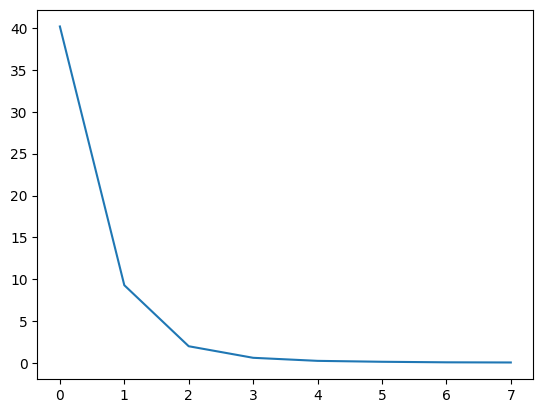

In [18]:
def generate_wavenumbers(n=6):
    """Generate the wavenumbers."""
    # n = 7  # Size of the square array
    center = n // 2  # Center of the array
    array = np.zeros((n, n), dtype=int)

    # Fill values based on distance from the center
    for i in range(n):
        for j in range(n):
            distance = max(abs(center - i), abs(center - j))
            array[i, j] = distance

    # For even-sized arrays, ensure the center area avoids 0 directly
    if n % 2 == 0:
        for i in range(n):
            for j in range(n):
                if i + j >= n:
                    array[i, j] += 1
    return array


# Generate and print the array
array = generate_wavenumbers(n=8)
print(array)


def custom_2d_spectrum(signal, n_observations, normalize=True):
    """Calculate 2d spectrum of data."""
    signal = signal.cpu()
    t = signal.shape[0]
    signal = signal.view(t, n_observations, n_observations)

    if normalize:
        signal = torch.fft.fft2(signal, norm='ortho')
    else:
        signal = torch.fft.rfft2(
            signal, s=(n_observations, n_observations), norm='backward'
        )

    # center FFT
    centered_fft_signal = torch.fft.fftshift(signal)

    # compute energy
    energy = centered_fft_signal.abs() ** 2

    # define wavenumbers
    wave_numbers = generate_wavenumbers(n=n_observations)
    max_wavenumber = n_observations // 2

    # spectrum = torch.zeros((T, n_observations))
    # for i in range(max_wavenumber):
    #    energies = torch.where(torch.tensor(wave_numbers) == i, energy, 0)

    spectrum = torch.zeros((t, n_observations // 2))
    for j in range(1, max_wavenumber + 1):
        ind = torch.where(torch.tensor(wave_numbers) == j)
        spectrum[:, j - 1] = energy[:, ind[0], ind[1]].sum(dim=1)

    spectrum = spectrum.mean(dim=0)
    return spectrum


spectrum = custom_2d_spectrum(out, 16)
plt.plot(spectrum)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 


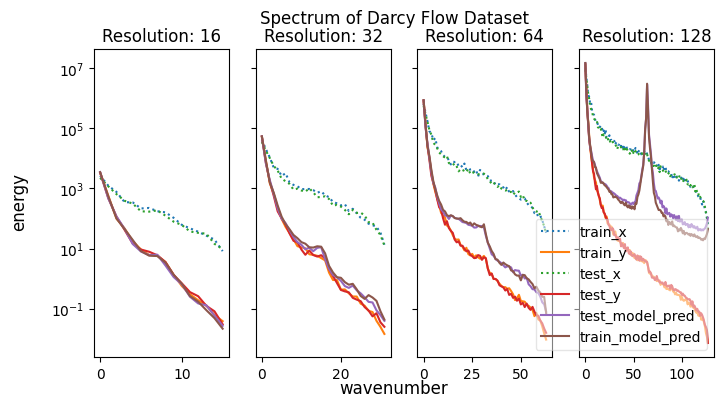

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 


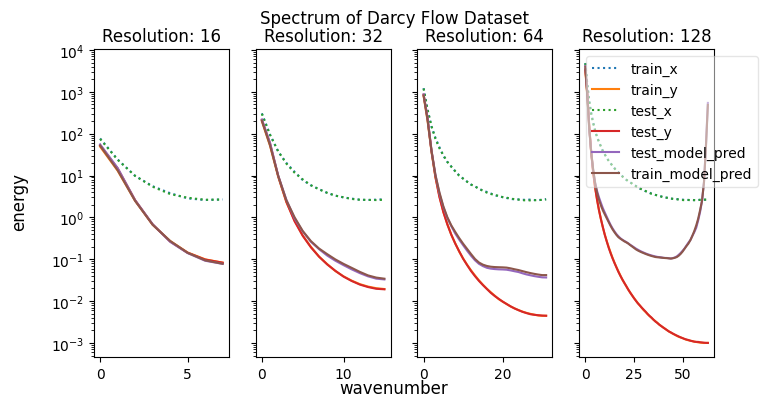

In [19]:
for spectrum_func in [spectrum_2d, custom_2d_spectrum]:
    fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharey='row')

    model = trained_models[16]
    model = model.to(device)
    model = model.eval()

    for idx, s in enumerate([16, 32, 64, 128]):
        ## Define some variables
        T = 500  # number of time steps
        samples = 50
        # s = 16 # resolution of the dataset

        # additional paramaters for the dataset
        Re = 5000
        index = 1
        T = 100
        dataset_name = 'Darcy Flow'

        train_loader, test_loaders, output_encoder = load_darcy_flow_small(
            n_train=1000,
            # batch_size=16,
            train_resolution=s,
            test_resolutions=[16, 32, 64, 128],
            n_tests=[100, 100, 100, 100],
            # test_batch_sizes=[32, 32, 32, 32],
        )

        # It is important to note that we want the last two dimensions
        # to represent the spatial dimensions
        # So in some cases one might have to permute the
        # dataset after squeezing
        # the initial dimensions as well

        # squeeze the dataset to remove the empty channel dimension
        dataset_pred = train_loader.dataset[:samples]['x'].squeeze()
        dataset_pred_y = train_loader.dataset[:samples]['y'].squeeze()
        model_preds_train = get_model_preds(train_loader, model).squeeze()
        model_preds_test = get_model_preds(test_loaders[s], model).squeeze()
        # Shape of the dataset
        shape = dataset_pred.shape

        # Generate the spectrum of the dataset
        # We reshape our samples into the form expected by ``spectrum_2d``:
        # ``(n_samples, h, w)``
        train_sp_x = spectrum_func(dataset_pred.reshape(samples * 1, s, s), s)
        train_sp_y = spectrum_func(
            dataset_pred_y.reshape(samples * 1, s, s), s
        )
        train_sp_model_pred = spectrum_func(
            model_preds_train[:samples].reshape(samples * 1, s, s), s
        )

        test_sp_x = spectrum_func(
            test_loaders[s]
            .dataset[:samples]['x']
            .squeeze()
            .reshape(samples * 1, s, s),
            s,
        )
        test_sp_y = spectrum_func(
            test_loaders[s]
            .dataset[:samples]['y']
            .squeeze()
            .reshape(samples * 1, s, s),
            s,
        )
        test_sp_model_pred = spectrum_func(
            model_preds_test[:samples].reshape(samples * 1, s, s), s
        )
        # Configure pyplot and generate the plot

        ax[idx].set_yscale('log')

        length = dataset_pred.shape[-1]  # the resolution length of the dataset
        buffer = 10  # just add a buffer to the plot
        k = np.arange(length + buffer) * 1.0
        ax[idx].plot(train_sp_x, linestyle=':', label='train_x')
        ax[idx].plot(train_sp_y, linestyle='-', label='train_y')
        ax[idx].plot(test_sp_x, linestyle=':', label='test_x')
        ax[idx].plot(test_sp_y, linestyle='-', label='test_y')
        ax[idx].plot(
            test_sp_model_pred, linestyle='-', label='test_model_pred'
        )
        ax[idx].plot(
            train_sp_model_pred, linestyle='-', label='train_model_pred'
        )

        ax[idx].set_title(f'Resolution: {s}')
        fig.suptitle(f'Spectrum of {dataset_name} Dataset')

    fig.supxlabel('wavenumber')
    fig.supylabel('energy')

    # show the figure
    leg = plt.legend(loc='best')
    leg.get_frame().set_alpha(0.5)
    plt.show()

# Compute loss on different Frequencies

- https://github.com/pdebench/PDEBench/blob/main/pdebench/models/metrics.py#L257C5-L296C1

- Visualize Samples @ different resolutions + frequencies (ground truth vs. model predictions)

- Compute FrMSE loss

- Normalized FRMSE by energy in each frequency bin

In [ ]:
df = pd.DataFrame(
    columns=['train_resolution', 'test_resolution', 'loss_type', 'loss'],
)

for train_resolution in [16]:
    # get data
    train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000,
        # batch_size=16,
        train_resolution=train_resolution,
        test_resolutions=[16, 32, 64, 128],
        n_tests=[100, 100, 100, 100],
        # test_batch_sizes=[32, 32, 32, 32],
    )

    # incrementally vary modes
    incremental = True
    starting_modes = (16, 16)
    if incremental:
        starting_modes = (2, 2)

    # Set up model
    model = FNO(
        max_n_modes=(16, 16),
        n_modes=starting_modes,
        hidden_channels=32,
        in_channels=1,
        out_channels=1,
    )
    model = model.to(device)
    n_params = count_model_params(model)

    # optimizer + data
    optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    data_transform = IncrementalDataProcessor(
        in_normalizer=None,
        out_normalizer=None,
        device=device,
        subsampling_rates=[2, 1],
        dataset_resolution=16,
        dataset_indices=[2, 3],
        epoch_gap=10,
        verbose=True,
    )

    data_transform = data_transform.to(device)

    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    train_loss = h1loss
    eval_losses = {'h1': h1loss, 'l2': l2loss}
    print('\n### N PARAMS ###\n', n_params)
    print('\n### OPTIMIZER ###\n', optimizer)
    print('\n### SCHEDULER ###\n', scheduler)
    print('\n### LOSSES ###')
    print('\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###')
    print(f'\n * Train: {train_loss}')
    print(f'\n * Test: {eval_losses}')
    sys.stdout.flush()

    # Finally pass all of these to the Trainer
    trainer = IncrementalFNOTrainer(
        model=model,
        n_epochs=20,
        data_processor=data_transform,
        device=device,
        verbose=False,
        incremental_loss_gap=False,
        incremental_grad=True,
        incremental_grad_eps=0.9999,
        incremental_loss_eps=0.001,
        incremental_buffer=5,
        incremental_max_iter=1,
        incremental_grad_max_iter=2,
    )

    # train
    end_stats = trainer.train(
        train_loader,
        test_loaders,
        optimizer,
        scheduler,
        regularizer=False,
        training_loss=train_loss,
        eval_losses=eval_losses,
    )

    # save stats
    for k, v in end_stats.items():
        s = k.split('_')

        if 'h1' in s or ('l2' in s):
            row = {
                'train_resolution': train_resolution,
                'test_resolution': s[0],
                'loss_type': s[1],
                'loss': v.item(),
            }
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

In [ ]:
model = trainer.model
model = model.to(device)
model = model.eval()
data_transform = data_transform.to(device)
for _idx, sample in enumerate(test_loaders[128]):  # resolution 32
    # print(sample['y'].shape)  # bs, 1 time step, x_dim, y_dim
    model_input = data_transform.preprocess(sample)
    # print(sample)
    with torch.no_grad():
        # with torch.autocast(device_type=device.type):
        out = model(**model_input)
        # out = model(x=sample['x'])

In [ ]:
trainer.eval_one_batch(sample, eval_losses)

In [ ]:
eval_losses

In [ ]:
out.shape

In [ ]:
def frmse_2d(
    pred: torch.Tensor,
    target: torch.Tensor,
    scaling_factors: tuple(int, int) = (1.0, 1.0),
    i_low: int = 4,
    i_high: int = 12,
) -> torch.Tensor:
    """Loss on diffrent frequencies."""
    # initial_step = 1
    # pred = pred[..., initial_step:, :]
    # target = target[..., initial_step:, :]

    print(pred.shape)

    # pred = pred.permute(0, 4, 1, 2, 3)
    # target = target.permute(0, 4, 1, 2, 3)
    idxs = target.size()
    nb, nt = idxs[0], idxs[1]

    lx, ly = scaling_factors

    pred_freq = torch.fft.fftn(pred, dim=[2, 3])
    target_freq = torch.fft.fftn(target, dim=[2, 3])
    nx, ny = idxs[2:4]
    _err_freq = torch.abs(pred_freq - target_freq) ** 2

    err_freq = torch.zeros([nb, min(nx // 2, ny // 2), nt]).to(device)

    for i in range(nx // 2):
        for j in range(ny // 2):
            it = math.floor(math.sqrt(i**2 + j**2))
            if it > min(nx // 2, ny // 2) - 1:
                continue
            err_freq[:, it] += _err_freq[:, :, i, j]

    _err_freq = torch.sqrt(torch.mean(err_freq, axis=0)) / (nx * ny) * lx * ly
    print(f'{_err_freq.shape=}')
    err_freq = torch.zeros([3, nt]).to(device)
    print(f'{err_freq.shape=}')
    # low freq
    err_freq[0] += torch.mean(_err_freq[:i_low, :], dim=0)

    # middle freq
    err_freq[1] += torch.mean(_err_freq[i_low:i_high, :], dim=0)

    # high freq
    err_freq[2] += torch.mean(_err_freq[i_high:, :], dim=0)

    return err_freq


model = trainer.model
frmse_2d(pred=out, target=sample['y'])

**Why does highest frequency info have the lowest loss? I would have expected the opposite. FM paper has the same trend? PDE bench has the same trend. Is there just not much high frequency information? Am I missing something (Do I have my understanding reversed)**


- Error on high frequency componenet should be scaled by the energy in the high frequency component
- Plot the High, medium, low frequency power spectrum (show that there is transition between the different bands)
- https://arxiv.org/pdf/2503.02113

Questions:
- fRMSE: RMSE in fourier space -- is it equivalent to compute loss in fourier space? Or should we filter different frequency bands and compute loss directly in the time domain? Why pick one over the other

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(sample['y'][0, 0, :, :].to('cpu'))
axs[0, 0].set_title('Ground truth')
axs[0, 1].imshow(out[0, 0, :, :].to('cpu'))
axs[0, 1].set_title('Model Prediction')

pred_freq = torch.fft.fftn(out, dim=[2, 3])
target_freq = torch.fft.fftn(sample['y'], dim=[2, 3])

# axs[1,0].imshow(target_freq[0,0,:,:].to("cpu"))
# axs[1,0].set_title("Ground truth")
# axs[1,1].imshow(pred_freq[0,0,:,:].to("cpu"))
# axs[1,1].set_title("Model Prediction")